In [ ]:
#일정량 이상의 마이너스 값이 들어가면 그거 학습 안시킬 것임.

k fold? 만큼 학습시킬것.
그다음? 카드 클릭하고 화면 클릭하는 경우만 가능하게 하고 그렇게 안했을 경우 train dataset에 넣지 말것.

In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import collections
import random
import matplotlib.pyplot as plt
import pyautogui as pag
import PIL
import torchvision.transforms as transforms
import cv2
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import time
import seaborn as sns
from torch.distributions import Categorical

pag.FAILSAFE = False


import argparse
import torch

import torch.multiprocessing as _mp
from torch.distributions import Categorical
import torch.nn.functional as F



import numpy as np
import shutil
from torch.utils.tensorboard import SummaryWriter


from random import sample

In [2]:
#env.py
class ENV():
    def __init__(self):
        # screenshot의 위치 지정, 클래스 생성할때 가져오기

        # winflg와 lose flag 존재해야 함. 0으로 하는 건 grayscale
        self.winFlag = cv2.imread('/home/jnu/Desktop/Reinforce/Royale/screenshot/cr_test/weWin.png', 0)
        self.loseFlag = cv2.imread('/home/jnu/Desktop/Reinforce/Royale/screenshot/cr_test/enemyWin.png', 0)
        # nocard flag
        self.nocardFlag = cv2.imread('/home/jnu/Desktop/Reinforce/Royale/screenshot/test1/nocard.png')
        # noElixir flag
        self.noelixirFlag = cv2.imread('/home/jnu/Desktop/Reinforce/Royale/screenshot/test1/noElixir.png')
        self.startGameFlag = cv2.imread('/home/jnu/Desktop/Reinforce/Royale/screenshot/cr_test/battleStart.png')
        self.finishFlag = cv2.imread('/home/jnu/Desktop/Reinforce/Royale/screenshot/cr_test/battleFinish.png')
        self.enemy1Flag = cv2.imread('/home/jnu/Desktop/Reinforce/Royale/screenshot/cr_test/enemy1.png')
        self.enemy2Flag = cv2.imread('/home/jnu/Desktop/Reinforce/Royale/screenshot/cr_test/enemy2.png')
        self.enemy3Flag = cv2.imread('/home/jnu/Desktop/Reinforce/Royale/screenshot/cr_test/enemy3.png')
        self.stop_flag = cv2.imread('/home/jnu/Desktop/Reinforce/Royale/screenshot/cr_test/stop_game_full.png')
        self.main_flag = cv2.imread('/home/jnu/Desktop/Reinforce/Royale/screenshot/cr_test/main_check.png')
        
    def return_state(self, img):
        # 스크린 샷을 인자로 받아와서 모델에 넣을 수 있도록 tensor로 변환
        tf = transforms.ToTensor()
        img_t = tf(img) # time.sleep(0.3)
        img_t = img_t.unsqueeze(0)
        # img_t = img_t.permute(1, 0, 2, 3)

        return img_t

    def check_finish(self,img):
        finishMessage = cv2.cvtColor(self.finishFlag, cv2.COLOR_BGR2GRAY)
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ratio = cv2.matchTemplate(finishMessage, img, cv2.TM_CCOEFF_NORMED)
        if (np.max(ratio) > 0.90):
            return 1

        else:
            return 0

    def check_win(self, img):
        # 게임이 이겼는지 확인, screenshot을 가져와서 우리가 원하는 크기로 잘라서 확인
        # img = np.array(img)
        checkFlag1 = np.array(img.crop((225, 335, 280, 365)))
        checkFlag1 = cv2.cvtColor(checkFlag1, cv2.COLOR_BGR2GRAY)
        win_check = cv2.matchTemplate(checkFlag1, self.winFlag, cv2.TM_CCOEFF_NORMED)
        if win_check > 0.8:
            return 1

        else:
            return 0
           
    def check_lose(self, img):
        # 게임이 졌는지 확인, screenshot을 가져와서 우리가 원하는 크기로 잘라서 확인
        # img = np.array(img)
        checkFlag2 = np.array(img.crop((225, 85, 280, 115)))
        checkFlag2 = cv2.cvtColor(checkFlag2, cv2.COLOR_BGR2GRAY)
        lose_check = cv2.matchTemplate(checkFlag2, self.loseFlag, cv2.TM_CCOEFF_NORMED)
        if lose_check > 0.8:
            return 1

        else:
            return 0

    def check_card(self, img):
        # 카드를 선택하지 않았는지 확인, screenshot을 가져와서 init에 지정된 nocard 이미지와 비교하여 reward 부여
        nocard = cv2.cvtColor(self.nocardFlag, cv2.COLOR_BGR2GRAY)
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ratio = cv2.matchTemplate(nocard, img, cv2.TM_CCOEFF_NORMED)

        if (np.max(ratio) > 0.90):
            # print(np.max(ratio))
            return 1

        else:
            return 0

    def check_elixir(self, img):
        noElixir = cv2.cvtColor(self.noelixirFlag, cv2.COLOR_BGR2GRAY)
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ratio = cv2.matchTemplate(noElixir, img, cv2.TM_CCOEFF_NORMED)

        if (np.max(ratio) > 0.90):
            # print(np.max(ratio))
            return 1

        else:
            return 0

    def checkET1(self, img):
        score1 = 0
        checkFlag1 = np.array(img.crop((105, 135, 155, 136)))

        for i in range(50):
            if (checkFlag1[0][i][0] >= 96):
                score1 += 1

        score1 = score1 * 2
        return score1

    def checkET2(self, img):
        score2 = 0
        checkFlag2 = np.array(img.crop((371, 135, 421, 136)))

        for i in range(50):
            if (checkFlag2[0][i][0] >= 96):
                score2 += 1

        score2 = score2 * 2
        return score2

    def checkGameStart(self, img):
        startMessage = cv2.cvtColor(self.startGameFlag, cv2.COLOR_BGR2GRAY)
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ratio = cv2.matchTemplate(startMessage, img, cv2.TM_CCOEFF_NORMED)
        if (np.max(ratio) > 0.90):
            # print(np.max(ratio))
            return 1

        else:
            return 0
        
    def checkMainPage(self, img):
        main_check = cv2.cvtColor(self.startGameFlag, cv2.COLOR_BGR2GRAY)
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ratio = cv2.matchTemplate(main_check, img, cv2.TM_CCOEFF_NORMED)
        if (np.max(ratio) > 0.90):
            # print(np.max(ratio))
            return 1

        else:
            return 0
        
    def stop_game(self, img):
        stopMessage = cv2.cvtColor(self.stop_flag, cv2.COLOR_BGR2GRAY)
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ratio = cv2.matchTemplate(stopMessage, img, cv2.TM_CCOEFF_NORMED)
        if (np.max(ratio) > 0.90):
            # print(np.max(ratio))
            return 1

        else:
            return 0

    def enemy1(self, img):
        crownFlag1 = cv2.cvtColor(self.enemy1Flag, cv2.COLOR_BGR2GRAY)
        img1 = np.array(img)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        ratio = cv2.matchTemplate(crownFlag1, img1, cv2.TM_CCOEFF_NORMED)
        #print(np.max(ratio))
        if (np.max(ratio) > 0.90):
            return 1
        else:
            return 0
        
    def enemy2(self, img):
        crownFlag2 = cv2.cvtColor(self.enemy2Flag, cv2.COLOR_BGR2GRAY)
        img1 = np.array(img)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        ratio = cv2.matchTemplate(crownFlag2, img1, cv2.TM_CCOEFF_NORMED)
        #print(np.max(ratio))
        if (np.max(ratio) > 0.90):
            return 1
        else:
            return 0
        
    def enemy3(self, img):
        crownFlag3 = cv2.cvtColor(self.enemy3Flag, cv2.COLOR_BGR2GRAY)
        img1 = np.array(img)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        ratio = cv2.matchTemplate(crownFlag3, img1, cv2.TM_CCOEFF_NORMED)
        #print(np.max(ratio))
        if (np.max(ratio) > 0.90):
            return 1
        else:
            return 0

    # def checkOT1
    # def checkOT1
    # def checkOT1

    # 우리 타워와 상대 타워의 hp를 확인하여 reward 부여

    def retryGame(self):
        time.sleep(8)
        pag.click((2860, 875))
        time.sleep(5)
        
        while(1):
            img = pag.screenshot(region=(2605, 100, 510, 900))
            if(self.checkMainPage(img)):
                break
            time.sleep(5)
                
        pag.click((3070, 185))
        time.sleep(5)
        pag.click((2920, 385))
        time.sleep(3)
        pag.click((2950, 615))



In [3]:
learning_rate = 0.0001
gamma = 0.98
lmbda = 0.95
eps_clip = 0.1
K_epoch = 10
T_horizon = 100

In [4]:
#model.py
class PPO(nn.Module):
    def __init__(self, num_actions):
        super(PPO, self).__init__()
        
        self.data = []
        
        self.conv1 = nn.Sequential(nn.Conv2d(3, 16, 3, stride=2, padding=1),
                                   # nn.BatchNorm2d(16),
                                   nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 3, stride=2, padding=1),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU(inplace=True))
        self.conv3 = nn.Sequential(nn.Conv2d(32, 64, 3, stride=2, padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(inplace=True))
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.actor_linear = nn.Sequential(nn.Linear(64, 64),
                                          nn.ReLU(inplace=True),
                                          nn.Linear(64, num_actions))
        self.critic_linear = nn.Sequential(nn.Linear(64, 64),
                                          nn.ReLU(inplace=True),
                                          nn.Linear(64, 1))
        self.optimizer = optim.Adam(self.parameters(), lr = learning_rate)
    
    def pi(self, x, softmax_dim = 0):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # x = self.actor_linear(x.reshape(x.size(0), -1))
        x = self.avgpool(x).reshape(x.size(0), -1)
        x = self.actor_linear(x)
        prob = F.softmax(x, dim = softmax_dim)
        return prob
    
    def v(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avgpool(x).reshape(x.size(0), -1)
        v = self.critic_linear(x.reshape(x.size(0), -1))
        return v
    
    def put_data(self, transition):
        self.data.append(transition)
        
    def clear_data(self):
        self.data = []
        
    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []
        
        for transition in self.data:
            s, a, r, s_prime, prob_a, done = transition
             
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            prob_a_lst.append(prob_a)
            done_mask = 0 if done else 1
            done_lst.append([done_mask])
            
        s_lst = torch.stack(s_lst).cuda()
        s_prime_lst = torch.stack(s_prime_lst).cuda()
        #print(f"type_slst = {type(s_lst)}")
        s,a,r,s_prime,done_mask, prob_a = s_lst, torch.tensor(a_lst).cuda(), \
                                          torch.tensor(r_lst).cuda(), s_prime_lst, \
                                          torch.tensor(done_lst, dtype=torch.float).cuda(), torch.tensor(prob_a_lst).cuda()
        #print(s.shape)
        s = s.squeeze()
        s_prime = s_prime.squeeze()
        s, s_prime, = s.cuda(), s_prime.cuda() 
        self.data = []
        return s, a, r, s_prime, done_mask, prob_a
            
    def train_net(self):
        s, a, r, s_prime, done_mask, prob_a = self.make_batch()
        #print(f"s size = {len(s)}, s_prime_size - {len(s_prime)}")
        
        global train_time
        #print(f"a = {a}")
        for i in range(K_epoch):
            train_time += 1
            td_target = r + gamma * self.v(s_prime) * done_mask
            delta = td_target - self.v(s)
            delta = delta.to("cpu")
            delta = delta.detach().numpy()           
            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype = torch.float).cuda()
            
            pi = self.pi(s, softmax_dim = 1)
            pi_a = pi.gather(1, a)
            #print(f"pi_a = {pi_a}, prob_A = {prob_a}")
            ratio = torch.exp(torch.log(pi_a) - torch.log(prob_a))
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
            #print(f"advantage = {advantage}")
            #print("=================")
            #print(f"surr1 = {surr1}, surr2 = {surr2}")
            loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(s), td_target.detach())
            #print(f"loss1 = {loss.mean()}")
            writer.add_scalar("Loss/train", loss.mean(), train_time)
            writer.flush()
            self.optimizer.zero_grad()
            loss.mean().backward()
            #loss.backward()
            self.optimizer.step()
            print(f"{i+1} train is over")
            
        

In [5]:
#train.py envs = MultipleEnvironments(opt.world, opt.stage, opt.action_type, opt.num_processes)
env = ENV()

In [6]:
#train.py model = PPO(envs.num_states, envs.num_actions)
model = PPO(45).cuda()

In [7]:
action_list = []
action_list_name = {}
count = 0
for i in range(5):
    for j in range(8):
        action_list.append((2655+j*58.571, 510+i*63.75))
        
        action_list_name[count] = str(i) + ' ' + str(j)
        count+=1
        
action_list.append([2765, 900])
action_list.append([2855, 940])
action_list.append([2950, 900])
action_list.append([3055, 900])
action_list.append([-1, -1])
action_list_name[40] = "card 1"
action_list_name[41] = "card 2"
action_list_name[42] = "card 3"
action_list_name[43] = "card 4"
action_list_name[44] = "rest action"

In [8]:
print(action_list)
print(action_list_name)

[(2655.0, 510.0), (2713.571, 510.0), (2772.142, 510.0), (2830.713, 510.0), (2889.284, 510.0), (2947.855, 510.0), (3006.426, 510.0), (3064.997, 510.0), (2655.0, 573.75), (2713.571, 573.75), (2772.142, 573.75), (2830.713, 573.75), (2889.284, 573.75), (2947.855, 573.75), (3006.426, 573.75), (3064.997, 573.75), (2655.0, 637.5), (2713.571, 637.5), (2772.142, 637.5), (2830.713, 637.5), (2889.284, 637.5), (2947.855, 637.5), (3006.426, 637.5), (3064.997, 637.5), (2655.0, 701.25), (2713.571, 701.25), (2772.142, 701.25), (2830.713, 701.25), (2889.284, 701.25), (2947.855, 701.25), (3006.426, 701.25), (3064.997, 701.25), (2655.0, 765.0), (2713.571, 765.0), (2772.142, 765.0), (2830.713, 765.0), (2889.284, 765.0), (2947.855, 765.0), (3006.426, 765.0), (3064.997, 765.0), [2765, 900], [2855, 940], [2950, 900], [3055, 900], [-1, -1]]
{0: '0 0', 1: '0 1', 2: '0 2', 3: '0 3', 4: '0 4', 5: '0 5', 6: '0 6', 7: '0 7', 8: '1 0', 9: '1 1', 10: '1 2', 11: '1 3', 12: '1 4', 13: '1 5', 14: '1 6', 15: '1 7', 16: 

In [9]:
writer = SummaryWriter()

2023-08-21 13:51:14.040370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
#train.py curr_episode = 0
curr_episode = 0
train_time = 0
play_time = 0

In [11]:
while True:
    curr_episode += 1
    
    
    #reward 초기화
    r = 0
    
    #done 초기화
    done = 0
    
    # enemy tower score / score1 = left, score2 = right
    score1 = 100
    score2 = 100
    
    num_local_steps = 0
    
    #set start_flag
    start_flag = 0
    
    #승리 패배를 기록
    win_lose_flag = 0
    
    #s라는 변수는 이렇다는 것을 보여주기 위한 구문
    img = pag.screenshot(region=(2605, 100, 510, 900))
    s = env.return_state(img).cuda()
    right_click_flag = 0
    play_time += 1
    
    card_click_flag = 0
    real_click_flag = 0
    while(1):
    #for _ in range(40):
        #opt 기본 num_local_steps = 512
        
        #게임 시작 확인 전까지 멈춤 지시
        while (start_flag == 0):
            # 스크린샷 찍기
            img = pag.screenshot(region=(2605, 100, 510, 900))

            if (env.checkGameStart(img)):
                print("game start")
                start_flag = 1
                time.sleep(3)
                #현재 이미지 캡처 후 변환
                img = pag.screenshot(region=(2605, 100, 510, 900))
                s = env.return_state(img).cuda()
                break
                
#         img = pag.screenshot(region=(2605, 100, 510, 900))
#         s = env.return_state(img).cuda()
        
        for t in range(T_horizon):        

            #num_local_step_count
            num_local_steps += 1



            prob = model.pi(s, softmax_dim=1)
            #print(f"prob = {prob}")
            m = Categorical(prob)
            a = m.sample().item()



            if(a >= 40 and a <= 43):
                right_click_flag = 1

            if(right_click_flag == 1 and a >= 0 and a <= 39):
                print("right_click")
                r+= 50
                right_click_flag = 0


#             if(a >= 40 and a <= 43):
#                 card_click_flag = 1
#                 real_click_flag = 1

#             if(card_click_flag == 1 and a >= 0 and a <= 39):
#                 real_click_flag = 1
#                 card_click_flag = 0
            #print(f"action = {action_list_name[a]}")

            print(f"a = {a}")
            #pag 클릭. rest action은 -1 -1 이므로 실행하지 않음
#             if(a!=44 and real_click_flag == 1):
#                 # 화면 클릭
#                 pag.click(action_list[a][0], action_list[a][1])
#                 time.sleep(0.3)
#                 real_click_flag = 0
            if(a!=44):
                # 화면 클릭
                pag.click(action_list[a][0], action_list[a][1])
                time.sleep(0.3)
                


            #클릭 한번당 reward -1
            r -= 1

            # 승리 확인
            if (env.check_win(img)):
                print("win")
                r += 5000
                done = 1
                win_lose_flag = 1

            # 패배 확인
            if (env.check_lose(img)):
                print("lose")
                r -= 5000
                done = 1
                win_lose_flag = -1

            # no card확인
            if (env.check_card(img)):
                r -= 20
                print("no card")

            # no elixir확인
            if (env.check_elixir(img)):
                r -= 20
                print("no Elixir")

            if (env.enemy1(img)):
                r -= 100
                print("crown - 1")

            if (env.enemy2(img)):
                r -= 100
                print("crown - 2")

            if (env.enemy3(img)):
                r -= 5000
                done = 1
                print("crown - 3")


            # enemy tower reward calculate
            score1_now = env.checkET1(img)
            score2_now = env.checkET2(img)
            #print(f"score1 = {score1}, score1_now = {score1_now}")
            #print(f"score2 = {score2}, score2_now = {score2_now}")
            print(f"left tower HP = {score1}, right tower HP = {score2}")
            print(f"reward = {r}")
            if (score1_now < score1):
                r += 10 * (score1 - score1_now)
                score1 = score1_now

            if (score2_now < score2):
                r += 105 * (score2 - score2_now)
                score2 = score2_now


            #현재 이미지 캡처 후 변환
            img = pag.screenshot(region=(2605, 100, 510, 900))
            s_prime = env.return_state(img).cuda()
            #print(prob)
            model.put_data((s, a, r, s_prime, prob[0][a], done))

            s = s_prime
            if done:
                break

            if(r<-10000):
                print("too bad result")
                pag.click((2650, 850))
                #게임 X클릭
                time.sleep(0.5)
                img = pag.screenshot(region=(2605, 100, 510, 900))
                if(env.stop_game(img)):
                    pag.click((2930, 650))
                    model.clear_data()
                    break
            
            
        model.train_net()
        
        
        print(f"how many time to train? = {train_time}")
            #opt.save_interval = 50
        
        save_interval = 500
        if(train_time % save_interval == 0):
            #print("Episode: {}. Total loss: {}, save_interval = {}".format(curr_episode, total_loss, curr_episode % save_interval))
            torch.save(model.state_dict(),"{}/clash_royale_PPO_v2_{}".format("trained_models", train_time))
        
        if done:
            
            writer.add_scalar("reward/epi", r, play_time)
            writer.flush()
            writer.add_scalar("clicks/epi", num_local_steps, play_time)
            writer.flush()
            writer.add_scalar("win_lose/epi", win_lose_flag, play_time)
            writer.flush()
            break
    print("retry game")
    env.retryGame()

game start
a = 28
left tower HP = 100, right tower HP = 100
reward = -1
a = 15
left tower HP = 100, right tower HP = 100
reward = -2
a = 16
no card
left tower HP = 100, right tower HP = 100
reward = -23
a = 29
no card
left tower HP = 100, right tower HP = 100
reward = -44
a = 14
left tower HP = 100, right tower HP = 100
reward = -45
a = 27
no card
left tower HP = 100, right tower HP = 100
reward = -66
a = 32
left tower HP = 100, right tower HP = 100
reward = -67
a = 11
no card
left tower HP = 100, right tower HP = 100
reward = -88
a = 13
no card
left tower HP = 100, right tower HP = 100
reward = -109
a = 37
no card
left tower HP = 100, right tower HP = 100
reward = -130
a = 29
no card
left tower HP = 100, right tower HP = 100
reward = -151
a = 11
left tower HP = 100, right tower HP = 100
reward = -152
a = 28
no card
left tower HP = 100, right tower HP = 100
reward = -173
a = 10
left tower HP = 100, right tower HP = 100
reward = -174
a = 36
no card
left tower HP = 100, right tower HP = 

KeyboardInterrupt: 

In [16]:
card_click_flag = 1pag.click((2650, 850))
#게임 X

In [23]:
pag.click((2900, 650))
#게임종료

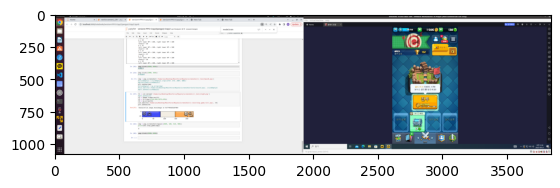

In [55]:
img = pag.screenshot('/home/jnu/Desktop/Reinforce/Royale/screenshot/cr_test/main0.png')
#clickEmpty1 = clickEmpty1.crop((2737, 573, 2987, 600))
#print(type(clickEmpty1))
plt.imshow(img)
#clickEmpty2 = np.array(img)
#cv2.imwrite('/home/jnu/Desktop/Reinforce/Royale/screenshot/test1/nocard.png', clickEmpty2)
#plt.imshow(clickEmpty1)

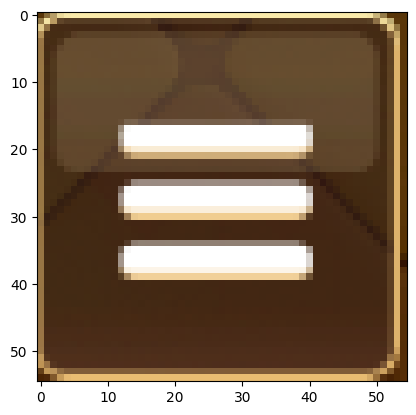

In [65]:
t1 = cv2.imread('/home/jnu/Desktop/Reinforce/Royale/screenshot/cr_test/main0.png')
#plt.imshow(t1)
t2 = Image.fromarray(t1)
t3 = t2.crop((3050,165,3105,220))
t4 = np.array(t3)
cv2.imwrite('/home/jnu/Desktop/Reinforce/Royale/screenshot/cr_test/main_check.png', t4)
plt.imshow(t4)

In [42]:
img = pag.screenshot(region=(2605, 100, 510, 900))
print(env.stop_game(img))

0


In [48]:
pag.click((2930, 650))

In [ ]:
들들와있음?
먼저하
i start first?
yes until when?
maybe 4?
ummm.. 
you don;t have to pacticipate?
untill 4 we are now OT
ok you use
BYe
Do clash royale and unity both can play?
no clash royale have to click
but I can do only until 5
so I will use only 4~5
what is concept about unity project? what will we do?
I am just starting but in githun it randaomly create cube and the robot moves cube to upper paper?
We have to train to move cube using robot arm.
using RL?
maybe
move cube using robot arm we have to train
we will do clash royale rl using night time
Then you are not doing now???
you start first
i ohka
okok
okok